In [2]:
!pip install -q flwr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.1/598.1 kB 4.1 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.8 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you have google-api-core 1.34.1 which is incompatible.
google-cloud-bigtable 2.30.0 requires google-api-core[grpc]<3.0.0,>=2.16.0, but you have google-api-core 1.34

In [3]:
!pip install -U flwr

In [4]:
# --- Imports ---
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import pandas as pd
import gc
import flwr as fl
from flwr.client import NumPyClient
from flwr.common import Context
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
import time

# --- Load and prepare data ---
data = np.load("/kaggle/input/daicwoz-balanced/dataset_balanced.npz")
test_ids = np.load("/kaggle/input/daicwoz-balanced/test_ids (1).npy")

X_audio_test = data["X_audio_test"]
X_text_test = data["X_text_test"]
y_test = data["y_test"]

X_audio_dev = data["X_audio_dev"]
X_text_dev = data["X_text_dev"]
y_dev = data["y_dev"]

X_audio_train = data["X_audio_train"]
X_text_train = data["X_text_train"]
y_train = data["y_train"]

y_train = y_train.reshape(-1, 1)
y_dev = y_dev.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# --- Parameters ---
NUM_CLIENTS = 10
input_shape_audio = (378, 60)
input_shape_text = (378, 9)

# --- Build model ---
def build_model():
    input_audio = layers.Input(shape=input_shape_audio, name='mfcc_input')
    x_audio = layers.LSTM(60, return_sequences=True, recurrent_dropout=0.002,
                          bias_regularizer=regularizers.l1_l2(1e-4, 1e-4))(input_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)
    x_audio = layers.LSTM(40, return_sequences=True, recurrent_dropout=0.002,
                          bias_regularizer=regularizers.l1_l2(1e-4, 1e-4))(x_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)
    x_audio = layers.LSTM(20, return_sequences=False, recurrent_dropout=0.002,
                          bias_regularizer=regularizers.l1_l2(1e-4, 1e-4))(x_audio)
    x_audio = layers.BatchNormalization()(x_audio)
    x_audio = layers.Dropout(2e-4)(x_audio)

    input_text = layers.Input(shape=input_shape_text, name='text_input')
    x_text = layers.Flatten()(input_text)

    x = layers.Concatenate()([x_audio, x_text])
    x = layers.Reshape((1, -1))(x)
    x = layers.LSTM(20, return_sequences=False, recurrent_dropout=0.002)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(2e-4)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(15, activation='tanh')(x)
    x = layers.Dense(10, activation='tanh')(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    return models.Model(inputs=[input_audio, input_text], outputs=output)

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def compile_model():
    model = build_model()
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(1e-5),
        loss=rmse,
        metrics=['accuracy', 'mae', rmse]
    )
    return model

def split_data(num_clients):
    size = len(y_train) // num_clients
    return [
        (X_audio_train[i * size : (i + 1) * size if i != num_clients - 1 else None],
         X_text_train[i * size : (i + 1) * size if i != num_clients - 1 else None],
         y_train[i * size : (i + 1) * size if i != num_clients - 1 else None])
        for i in range(num_clients)
    ]

client_datasets = split_data(NUM_CLIENTS)

# --- Global Metrics ---
global_metrics = {
    "accuracy": [],
    "mae": [],
    "rmse": [],
    "f1_score": [],
    "precision": [],
    "recall": [],
    "comm_bytes": [],
    "round_time_sec": []
}

def get_model_size(weights):
    return sum([w.nbytes for w in weights])

# --- Flower Client ---
class DepressionClient(NumPyClient):
    def __init__(self, model, X_audio_c, X_text_c, y_c):
        self.model = model
        self.X_audio_train = X_audio_c
        self.X_text_train = X_text_c
        self.y_train = y_c
        self.X_audio_test = X_audio_dev
        self.X_text_test = X_text_dev
        self.y_test = y_dev

    def get_parameters(self, config=None):
        return self.model.get_weights()

    def set_parameters(self, parameters):
        self.model.set_weights(parameters)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        self.model.fit(
            [self.X_audio_train, self.X_text_train],
            self.y_train,
            batch_size=8,
            epochs=2,
            verbose=0,
            shuffle=True,
        )
        return self.get_parameters(), len(self.y_train), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, acc, mae, rmse_val = self.model.evaluate(
            [self.X_audio_test, self.X_text_test], self.y_test, verbose=1
        )
        return float(loss), len(self.y_test), {
            "accuracy": float(acc),
            "mae": float(mae),
            "rmse": float(rmse_val)
        }

# --- Client App ---
def client_fn(context: Context):
    partition_id = int(context.node_config.get("partition-id", 0))
    model = compile_model()
    X_audio_c, X_text_c, y_c = client_datasets[partition_id]
    return DepressionClient(model, X_audio_c, X_text_c, y_c).to_client()

client_app = fl.client.ClientApp(client_fn=client_fn)

# --- Server App ---
def server_fn(context: Context) -> ServerAppComponents:
    model = compile_model()

    def evaluate_fn(server_round, parameters, _config):
        start = time.time()

        model.set_weights(parameters)
        y_pred = model.predict([X_audio_test, X_text_test])
        y_pred_labels = (y_pred > 0.5).astype(int)

        acc = accuracy_score(y_test, y_pred_labels)
        f1 = f1_score(y_test, y_pred_labels)
        prec = precision_score(y_test, y_pred_labels)
        rec = recall_score(y_test, y_pred_labels)
        mae_val = np.mean(np.abs(y_test - y_pred))
        rmse_val = np.sqrt(np.mean((y_test - y_pred) ** 2))

        bytes_per_round = get_model_size(parameters) * NUM_CLIENTS * 2
        round_time = time.time() - start

        global_metrics["accuracy"].append(acc)
        global_metrics["mae"].append(mae_val)
        global_metrics["rmse"].append(rmse_val)
        global_metrics["f1_score"].append(f1)
        global_metrics["precision"].append(prec)
        global_metrics["recall"].append(rec)
        global_metrics["comm_bytes"].append(bytes_per_round)
        global_metrics["round_time_sec"].append(round_time)

        print(f"\n\U0001F4CA Round {server_round}: Acc={acc:.4f}, F1={f1:.4f}, MAE={mae_val:.4f}, RMSE={rmse_val:.4f}, Bytes={bytes_per_round}, Time={round_time:.2f}s")

        tf.keras.backend.clear_session()
        gc.collect()

        return float(rmse_val), {
            "accuracy": float(acc),
            "f1_score": float(f1),
            "precision": float(prec),
            "recall": float(rec),
            "mae": float(mae_val),
            "rmse": float(rmse_val),
            "comm_bytes": bytes_per_round,
            "round_time_sec": round_time
        }

    strategy = FedAvg(
        fraction_fit=0.8,
        fraction_evaluate=0.5,
        min_fit_clients=NUM_CLIENTS,
        min_evaluate_clients=5,
        min_available_clients=NUM_CLIENTS,
        evaluate_fn=evaluate_fn,
    )

    return ServerAppComponents(strategy=strategy, config=ServerConfig(num_rounds=5))

server_app = ServerApp(server_fn=server_fn)

# --- Backend Resources ---
DEVICE = "cpu"
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}
if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

# --- Run Simulation ---
run_simulation(
    server_app=server_app,
    client_app=client_app,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

2025-07-03 16:10:28.673512: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=568) 2025-07-03 16:10:39.876895: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=567) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=567) E0000 00:00:1751559039.930315     567 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=568) E0000 00:00:1751559039.957965     568 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plug

44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step

📊 Round 0: Acc=0.4928, F1=0.6512, MAE=0.5015, RMSE=0.5045, Bytes=26125280, Time=10.87s


INFO :      initial parameters (loss, other metrics): 0.5045140385627747, {'accuracy': 0.492816091954023, 'f1_score': 0.6511857707509882, 'precision': 0.49623493975903615, 'recall': 0.9468390804597702, 'mae': 0.5014973878860474, 'rmse': 0.5045140385627747, 'comm_bytes': 26125280, 'round_time_sec': 10.872397422790527}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=569) 2025-07-03 16:11:03.596554: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
(ClientAppActor pid=567) 2025-07-03 16:11:03.602320: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step

📊 Round 1: Acc=0.4986, F1=0.4547, MAE=0.5024, RMSE=0.5111, Bytes=26125280, Time=8.01s


INFO :      fit progress: (1, 0.5110730528831482, {'accuracy': 0.4985632183908046, 'f1_score': 0.45468749999999997, 'precision': 0.4982876712328767, 'recall': 0.41810344827586204, 'mae': 0.5024166107177734, 'rmse': 0.5110730528831482, 'comm_bytes': 26125280, 'round_time_sec': 8.01335096359253}, 1161.998146213)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


 1/44 ━━━━━━━━━━━━━━━━━━━━ 3:54 5s/step - accuracy: 0.6875 - loss: 0.5171 - mae: 0.4868 - rmse: 0.4932
 2/44 ━━━━━━━━━━━━━━━━━━━━ 24s 595ms/step - accuracy: 0.6562 - loss: 0.5166 - mae: 0.4865 - rmse: 0.4926
 3/44 ━━━━━━━━━━━━━━━━━━━━ 24s 599ms/step - accuracy: 0.6632 - loss: 0.5169 - mae: 0.4868 - rmse: 0.4929
 1/44 ━━━━━━━━━━━━━━━━━━━━ 3:59 6s/step - accuracy: 0.6875 - loss: 0.5171 - mae: 0.4868 - rmse: 0.4932 [repeated 3x across cluster]
 2/44 ━━━━━━━━━━━━━━━━━━━━ 24s 588ms/step - accuracy: 0.6562 - loss: 0.5166 - mae: 0.4865 - rmse: 0.4926 [repeated 3x across cluster]
11/44 ━━━━━━━━━━━━━━━━━━━━ 20s 631ms/step - accuracy: 0.6315 - loss: 0.5197 - mae: 0.4884 - rmse: 0.4957 [repeated 33x across cluster]
20/44 ━━━━━━━━━━━━━━━━━━━━ 14s 600ms/step - accuracy: 0.6128 - loss: 0.5226 - mae: 0.4907 - rmse: 0.4986 [repeated 35x across cluster]
28/44 ━━━━━━━━━━━━━━━━━━━━ 9s 578ms/step - accuracy: 0.5962 - loss: 0.5252 - mae: 0.4931 - rmse: 0.5012
29/44 ━━━━━━━━━━━━━━━━━━━━ 8s 572ms/step - accu

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step

📊 Round 2: Acc=0.5036, F1=0.4350, MAE=0.4985, RMSE=0.5230, Bytes=26125280, Time=7.83s


INFO :      fit progress: (2, 0.5230491757392883, {'accuracy': 0.5035919540229885, 'f1_score': 0.4349959116925593, 'precision': 0.5047438330170778, 'recall': 0.382183908045977, 'mae': 0.49848678708076477, 'rmse': 0.5230491757392883, 'comm_bytes': 26125280, 'round_time_sec': 7.8254477977752686}, 2438.6927037550004)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
(raylet) Spilled 3012 MiB, 3 objects, write throughput 285 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(ClientAppActor pid=568) 2025-07-03 16:11:03.633478: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


 1/44 ━━━━━━━━━━━━━━━━━━━━ 6:59 10s/step - accuracy: 0.6562 - loss: 0.5026 - mae: 0.4595 - rmse: 0.4787
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5696 - loss: 0.5272 - mae: 0.4950 - rmse: 0.5032 [repeated 9x across cluster]
 3/44 ━━━━━━━━━━━━━━━━━━━━ 17s 438ms/step - accuracy: 0.6597 - loss: 0.5035 - mae: 0.4591 - rmse: 0.4795
 4/44 ━━━━━━━━━━━━━━━━━━━━ 17s 445ms/step - accuracy: 0.6452 - loss: 0.5083 - mae: 0.4639 - rmse: 0.4844
 5/44 ━━━━━━━━━━━━━━━━━━━━ 17s 444ms/step - accuracy: 0.6399 - loss: 0.5102 - mae: 0.4650 - rmse: 0.4863
 1/44 ━━━━━━━━━━━━━━━━━━━━ 7:49 11s/step - accuracy: 0.6562 - loss: 0.5026 - mae: 0.4595 - rmse: 0.4787 [repeated 3x across cluster]
 2/44 ━━━━━━━━━━━━━━━━━━━━ 20s 500ms/step - accuracy: 0.6562 - loss: 0.5030 - mae: 0.4587 - rmse: 0.4791 [repeated 4x across cluster]
11/44 ━━━━━━━━━━━━━━━━━━━━ 15s 477ms/step - accuracy: 0.6447 - loss: 0.5046 - mae: 0.4575 - rmse: 0.4806 [repeated 33x across cluster]
24/44 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - acc

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(raylet) Spilled 6024 MiB, 6 objects, write throughput 321 MiB/s.
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step

📊 Round 3: Acc=0.5000, F1=0.4304, MAE=0.4961, RMSE=0.5267, Bytes=26125280, Time=7.62s


INFO :      fit progress: (3, 0.5267316102981567, {'accuracy': 0.5, 'f1_score': 0.43044189852700493, 'precision': 0.5, 'recall': 0.37787356321839083, 'mae': 0.49607279896736145, 'rmse': 0.5267316102981567, 'comm_bytes': 26125280, 'round_time_sec': 7.617482900619507}, 3753.3968227739997)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


 1/44 ━━━━━━━━━━━━━━━━━━━━ 4:05 6s/step - accuracy: 0.6875 - loss: 0.4991 - mae: 0.4506 - rmse: 0.4752
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.5918 - loss: 0.5185 - mae: 0.4706 - rmse: 0.4946 [repeated 4x across cluster]
 2/44 ━━━━━━━━━━━━━━━━━━━━ 15s 375ms/step - accuracy: 0.6797 - loss: 0.5006 - mae: 0.4488 - rmse: 0.4766
 3/44 ━━━━━━━━━━━━━━━━━━━━ 19s 478ms/step - accuracy: 0.6823 - loss: 0.5003 - mae: 0.4483 - rmse: 0.4764
 4/44 ━━━━━━━━━━━━━━━━━━━━ 19s 476ms/step - accuracy: 0.6621 - loss: 0.5051 - mae: 0.4532 - rmse: 0.4812
 1/44 ━━━━━━━━━━━━━━━━━━━━ 4:15 6s/step - accuracy: 0.6875 - loss: 0.4991 - mae: 0.4506 - rmse: 0.4752 [repeated 3x across cluster]
 2/44 ━━━━━━━━━━━━━━━━━━━━ 21s 519ms/step - accuracy: 0.6797 - loss: 0.5006 - mae: 0.4488 - rmse: 0.4766 [repeated 3x across cluster]
10/44 ━━━━━━━━━━━━━━━━━━━━ 20s 596ms/step - accuracy: 0.6694 - loss: 0.4985 - mae: 0.4440 - rmse: 0.4746 [repeated 29x across cluster]
21/44 ━━━━━━━━━━━━━━━━━━━━ 11s 520ms/step - accu

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step

📊 Round 4: Acc=0.5043, F1=0.4279, MAE=0.4968, RMSE=0.5270, Bytes=26125280, Time=7.56s


INFO :      fit progress: (4, 0.5269884467124939, {'accuracy': 0.5043103448275862, 'f1_score': 0.42786069651741293, 'precision': 0.5058823529411764, 'recall': 0.3706896551724138, 'mae': 0.4968297779560089, 'rmse': 0.5269884467124939, 'comm_bytes': 26125280, 'round_time_sec': 7.564157962799072}, 5080.934046722)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


 1/44 ━━━━━━━━━━━━━━━━━━━━ 4:13 6s/step - accuracy: 0.6875 - loss: 0.4933 - mae: 0.4457 - rmse: 0.4694
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.6153 - loss: 0.5129 - mae: 0.4584 - rmse: 0.4890 [repeated 31x across cluster]
 2/44 ━━━━━━━━━━━━━━━━━━━━ 23s 559ms/step - accuracy: 0.6875 - loss: 0.4956 - mae: 0.4440 - rmse: 0.4717
 3/44 ━━━━━━━━━━━━━━━━━━━━ 21s 513ms/step - accuracy: 0.6979 - loss: 0.4951 - mae: 0.4430 - rmse: 0.4712
 4/44 ━━━━━━━━━━━━━━━━━━━━ 21s 532ms/step - accuracy: 0.6816 - loss: 0.4998 - mae: 0.4477 - rmse: 0.4759
 4/44 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6816 - loss: 0.4998 - mae: 0.4477 - rmse: 0.4759
 1/44 ━━━━━━━━━━━━━━━━━━━━ 4:33 6s/step - accuracy: 0.6875 - loss: 0.4933 - mae: 0.4457 - rmse: 0.4694 [repeated 3x across cluster]
 2/44 ━━━━━━━━━━━━━━━━━━━━ 30s 722ms/step - accuracy: 0.6875 - loss: 0.4956 - mae: 0.4440 - rmse: 0.4717 [repeated 3x across cluster]
 8/44 ━━━━━━━━━━━━━━━━━━━━ 26s 726ms/step - accuracy: 0.6800 - loss: 0.4970 - ma

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(raylet) Spilled 10041 MiB, 10 objects, write throughput 278 MiB/s.
INFO :      aggregate_fit: received 10 results and 0 failures


44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step

📊 Round 5: Acc=0.4993, F1=0.4078, MAE=0.4983, RMSE=0.5270, Bytes=26125280, Time=8.00s


INFO :      fit progress: (5, 0.527022659778595, {'accuracy': 0.4992816091954023, 'f1_score': 0.40781648258283776, 'precision': 0.498960498960499, 'recall': 0.3448275862068966, 'mae': 0.49831733107566833, 'rmse': 0.527022659778595, 'comm_bytes': 26125280, 'round_time_sec': 8.000605344772339}, 6444.282521493999)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


 1/44 ━━━━━━━━━━━━━━━━━━━━ 4:04 6s/step - accuracy: 0.7188 - loss: 0.4829 - mae: 0.4376 - rmse: 0.4590
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.6227 - loss: 0.5086 - mae: 0.4545 - rmse: 0.4847 [repeated 8x across cluster]
 2/44 ━━━━━━━━━━━━━━━━━━━━ 19s 470ms/step - accuracy: 0.7188 - loss: 0.4859 - mae: 0.4361 - rmse: 0.4620
 3/44 ━━━━━━━━━━━━━━━━━━━━ 18s 452ms/step - accuracy: 0.7292 - loss: 0.4854 - mae: 0.4349 - rmse: 0.4615
 1/44 ━━━━━━━━━━━━━━━━━━━━ 4:09 6s/step - accuracy: 0.7188 - loss: 0.4829 - mae: 0.4376 - rmse: 0.4590 [repeated 3x across cluster]
 2/44 ━━━━━━━━━━━━━━━━━━━━ 21s 516ms/step - accuracy: 0.7188 - loss: 0.4859 - mae: 0.4361 - rmse: 0.4620 [repeated 3x across cluster]
 9/44 ━━━━━━━━━━━━━━━━━━━━ 22s 655ms/step - accuracy: 0.7159 - loss: 0.4851 - mae: 0.4322 - rmse: 0.4612 [repeated 27x across cluster]
21/44 ━━━━━━━━━━━━━━━━━━━━ 12s 542ms/step - accuracy: 0.7132 - loss: 0.4821 - mae: 0.4287 - rmse: 0.4583 [repeated 45x across cluster]
27/44 ━━━━━━━━━━━━

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 6493.87s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.5282065868377686
INFO :      		round 2: 0.5357402563095093
INFO :      		round 3: 0.5373048186302185
INFO :      		round 4: 0.5363037586212158
INFO :      		round 5: 0.5350040197372437
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.5045140385627747
INFO :      		round 1: 0.5110730528831482
INFO :      		round 2: 0.5230491757392883
INFO :      		round 3: 0.5267316102981567
INFO :      		round 4: 0.5269884467124939
INFO :      		round 5: 0.527022659778595
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.492816091954023),
INFO :      	              (1, 0.4985632183908046),
INFO :      	              (2, 0.5035919540229885),
INFO :      	              (3, 0.5),
INFO :      	              (4, 0.5043103448275862),
INFO :      	    

43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.6457 - loss: 0.5019 - mae: 0.4495 - rmse: 0.4780 [repeated 8x across cluster]


In [5]:
# --- Save Metrics ---
pd.DataFrame(global_metrics).to_csv("fl_global_metrics.csv", index=False)

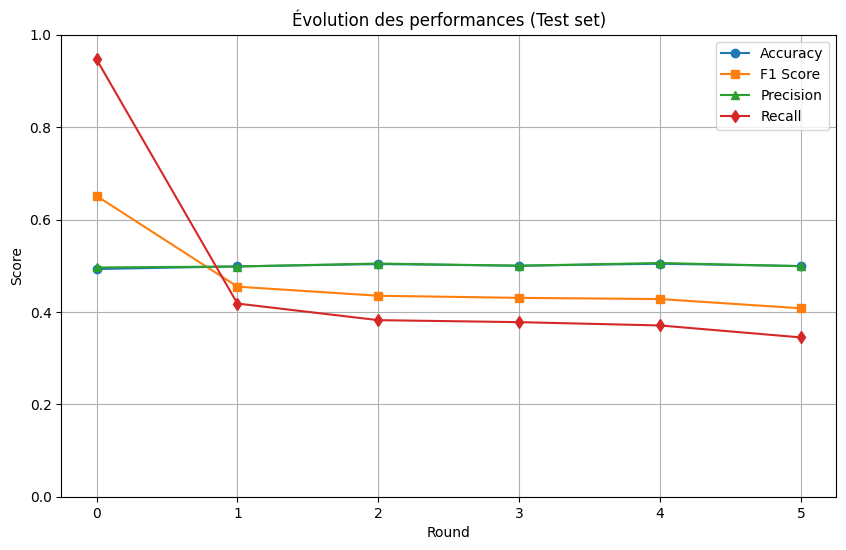

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger les métriques
df = pd.read_csv("fl_global_metrics.csv")

# Tracer les courbes de performance
plt.figure(figsize=(10, 6))
plt.plot(df["accuracy"], label="Accuracy", marker="o")
plt.plot(df["f1_score"], label="F1 Score", marker="s")
plt.plot(df["precision"], label="Precision", marker="^")
plt.plot(df["recall"], label="Recall", marker="d")
plt.title("Évolution des performances (Test set)")
plt.xlabel("Round")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()


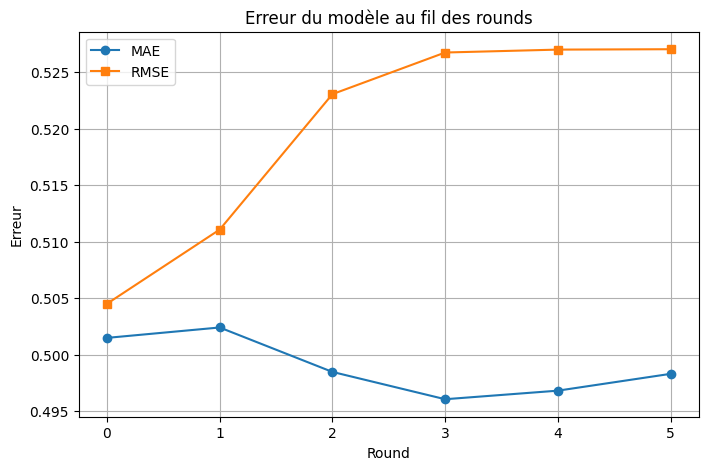

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(df["mae"], label="MAE", marker="o")
plt.plot(df["rmse"], label="RMSE", marker="s")
plt.title("Erreur du modèle au fil des rounds")
plt.xlabel("Round")
plt.ylabel("Erreur")
plt.legend()
plt.grid(True)
plt.show()


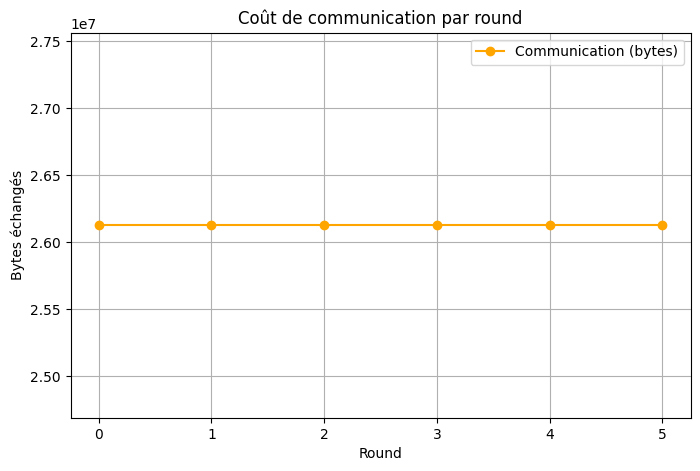

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(df["comm_bytes"], label="Communication (bytes)", color="orange", marker="o")
plt.title("Coût de communication par round")
plt.xlabel("Round")
plt.ylabel("Bytes échangés")
plt.grid(True)
plt.legend()
plt.show()


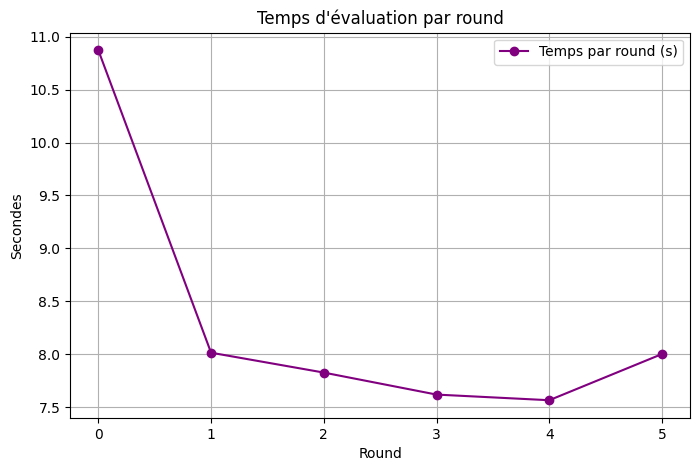

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(df["round_time_sec"], label="Temps par round (s)", color="purple", marker="o")
plt.title("Temps d'évaluation par round")
plt.xlabel("Round")
plt.ylabel("Secondes")
plt.grid(True)
plt.legend()
plt.show()


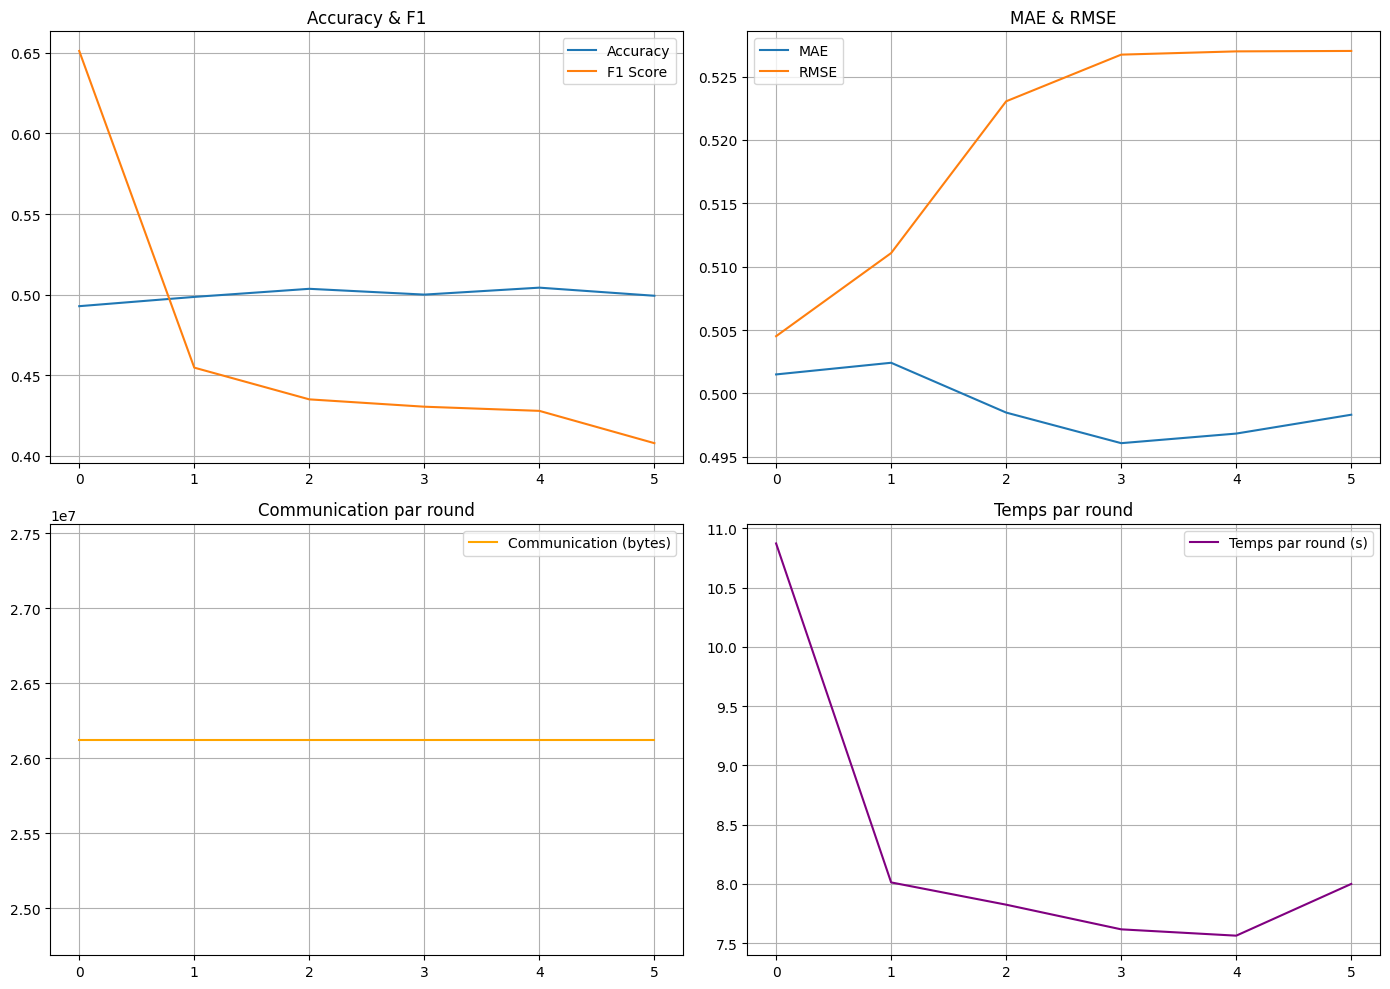

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy & F1
axs[0, 0].plot(df["accuracy"], label="Accuracy")
axs[0, 0].plot(df["f1_score"], label="F1 Score")
axs[0, 0].set_title("Accuracy & F1")
axs[0, 0].legend()
axs[0, 0].grid(True)

# MAE & RMSE
axs[0, 1].plot(df["mae"], label="MAE")
axs[0, 1].plot(df["rmse"], label="RMSE")
axs[0, 1].set_title("MAE & RMSE")
axs[0, 1].legend()
axs[0, 1].grid(True)

# Communication
axs[1, 0].plot(df["comm_bytes"], label="Communication (bytes)", color="orange")
axs[1, 0].set_title("Communication par round")
axs[1, 0].legend()
axs[1, 0].grid(True)

# Round Time
axs[1, 1].plot(df["round_time_sec"], label="Temps par round (s)", color="purple")
axs[1, 1].set_title("Temps par round")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()
